<h1>Capstone Project: Private Residential Property, Analysis by Street in Singapore</h1>
<h1>This notebook will be mainly used for the capstone project</h1>
<h4>Includes using location data in determining the suitable neighbourhoods, Clustering the neighbourhoods in Toronto</h4>


In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


In [3]:
!pip install geopy
!pip install folium==0.5.0
!pip install geocoder
!pip install seaborn
import urllib.request
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
from matplotlib import cm

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes

import folium # map rendering library
import requests
import geocoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 


Solving environment: done

# All requested packages already installed.



<h2>Introduction/ Business Problem</h2>


If you are a foreigner looking to move to Singapore, the more suitable option may be to go for a private apartment/condominium, let’s call them PACs. You may be a Singaporean looking to go private for the initial low minimum cash payment, a long-term investment, the less restrictions, or a single individual looking to own a property before the age of 35 (That is if you can afford to, really?). Private Condominiums/apartments come with facilities of a condominium (Gyms, security, swimming pools). There is no Minimum Occupancy Period (MOP) although you have to pay a Seller’s Stamp Duty (SSD) if you sell within 3 years. 

Executive Condominiums (ECs) on the other hand are a hybrid between private apartments (Private condominiums) and public housing (HDB flats) in Singapore. ECs are more suited for housing instead of investments/renting out for income because of the Minimum Occupancy Period (MOP) requirement of 5 years. Housing grants are also available for first time EC buyers. However, they are only available to Singapore Citizens and permanent residents. 

This project will be focused on private apartments/condominiums (excluding landed property) although future projects could dive into ECs.

It would be advantageous for new homebuyers be it if you’re a Singapore Citizen or a permanent resident, to know on the mean prices of each postal district to narrow down your choices and make better buying decisions. It may also be advantageous for real estate agents to help their clients make better choices.

References:
https://www.99.co/singapore/insider/7-reasons-a-private-property-is-more-affordable-than-you-think/
https://blog.moneysmart.sg/property/private-properties-hdbs-differences/
https://blog.seedly.sg/deciding-between-private-condominium-vs-executive-condominium/


A home buyer may have several considerations and preferences unique to individual.
This project aims to find out which postal district will be the best choice for your needs and budget. I hope that it will help you weigh the characteristics (e.g. public amenities, nearby restaurants) of certain postal districts with the prices better.

Homebuyers, real estate agents would be interested in the analysis of data categorized into different streets, each tagged to one private condominium nearby. This could factor into investment strategy or just a better quality of living. Tourist may also use the findings to choose their Airbnb location.


<h2>Data Discription</h2>


I used datasets of private apartments/condominiums from the Urban Redevelopment Authority website: https://www.ura.gov.sg/realEstateIIWeb/transaction/search.action
The datasets were dated from May 2016 to May 2021 and were downloaded 5 postal district numbers at once. There are 28 postal district numbers in total. 

I later converted the 6 CSV files downloaded into DataFrames and combined them into one. I then obtained the mean of the prices in each postal district. As the CSV did not contain the coordinates for each street name, I extracted the street names from the dataset of private properties and used the One map API to obtain the longitude and latitude coordinates based on the StreetName variable foe use in visualization. The coordinates were converted into a DataFrame and combined using a left outer join to fit all the coordinates into the original df_merged DataFrame. The mean price of PACs for each street was then calculated and complied into a new dataframe mapdata and eventually visualized onto a choropleth map.


In [5]:
df1 =pd.read_csv("/Users/joshualeow/Desktop/DataCondo/DataPrivate1.csv")
df2 =pd.read_csv("/Users/joshualeow/Desktop/DataCondo/DataPrivate2.csv")
df3 =pd.read_csv("/Users/joshualeow/Desktop/DataCondo/DataPrivate3.csv")
df4 =pd.read_csv("/Users/joshualeow/Desktop/DataCondo/DataPrivate4.csv")
df5 =pd.read_csv("/Users/joshualeow/Desktop/DataCondo/DataPrivate5.csv")
df6 =pd.read_csv("/Users/joshualeow/Desktop/DataCondo/DataPrivate6.csv")

frames = [df1, df2, df3, df4, df5, df6]

df_merged = pd.concat(frames)

df_merged.columns = df_merged.iloc[0]
df_merged = df_merged[1:]


df_merged.rename(columns={'level_0': 'S/N', 'level_1': 'ProjectName'}, inplace=True)
df_merged = df_merged.reset_index(drop=False).rename(columns={'level_0':'S/N', 'level_1':'ProjectName', 'level_2':'StreetName','level_3':'Type','level_4':'PostalDistrict','level_5':'MarketSegment','level_6':'Tenure','level_7':'TypeOfSale','level_8':'NoUnits','level_9':'Price','level_10':'NettPrice','level_11':'Sqft','level_12':'TypeOfArea','level_13':'FloorLevel','level_14':'UnitPrice','level_15':'DateOfSale'})


print(df_merged.columns.tolist())

df_merged.shape

['S/N', 'ProjectName', 'StreetName', 'Type', 'PostalDistrict', 'MarketSegment', 'Tenure', 'TypeOfSale', 'NoUnits', 'Price', 'NettPrice', 'Sqft', 'TypeOfArea', 'FloorLevel', 'UnitPrice', 'Date of Sale']


(96946, 16)

In [6]:

list_of_sn = df_merged['StreetName'].unique().tolist()
list_of_sn

['STIRLING ROAD',
 'CLEMENTI AVENUE 1',
 'CHIN SWEE ROAD',
 'SILAT AVENUE',
 'BERNAM STREET',
 'NORMANTON PARK',
 'SLIM BARRACKS RISE',
 'FABER WALK',
 'JALAN LEMPENG',
 'SPOTTISWOODE PARK ROAD',
 'WEST COAST CRESCENT',
 'WEST COAST VALE',
 'PEARL BANK',
 'ENG HOON STREET',
 'ALEXANDRA ROAD',
 'KEPPEL BAY DRIVE',
 'PASIR PANJANG HILL',
 'MOUNT FABER ROAD',
 'HARBOURFRONT AVENUE',
 'COVE WAY',
 'MISTRI ROAD',
 'CANTONMENT ROAD',
 'WEST COAST WAY',
 'PRINCE CHARLES CRESCENT',
 'COMMONWEALTH AVENUE',
 'ONE-NORTH GATEWAY',
 'WEST COAST ROAD',
 'DOVER RISE',
 'DUNDEE ROAD',
 'INDUS ROAD',
 'SOUTH BUONA VISTA ROAD',
 'WEST COAST WALK',
 'ALEXANDRA VIEW',
 'OCEAN DRIVE',
 'JIAK KIM STREET',
 'SHENTON WAY',
 'GOPENG STREET',
 'PARK ROAD',
 'CLUB STREET',
 'WEST COAST PARK',
 'MARINA BOULEVARD',
 'WALLICH STREET',
 'DEPOT ROAD',
 'ENGGOR STREET',
 'TELOK BLANGAH ROAD',
 'COVE DRIVE',
 'HAVELOCK ROAD',
 'WEST COAST RISE',
 'ROCHESTER DRIVE',
 'PASIR PANJANG ROAD',
 'KEPPEL BAY VIEW',
 'WEST COAS

In [7]:
prop_lat = []
prop_long = []
for i in range(0, len(list_of_sn)):
    query_address = list_of_sn[i]
    query_string = 'https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
    resp = requests.get(query_string)

    data_prop=json.loads(resp.content)
    
    if data_prop['found'] != 0:
        prop_lat.append(data_prop["results"][0]["LATITUDE"])
        prop_long.append(data_prop["results"][0]["LONGITUDE"])

        print (str(query_address)+",Lat: "+data_prop['results'][0]['LATITUDE'] +" Long: "+data_prop['results'][0]['LONGITUDE'])

    else:
        prop_lat.append('NotFound')
        prop_long.append('NotFound')
        print ("No Results")
        
# With reference from https://towardsdatascience.com/working-with-apis-in-data-science-explore-bit-rent-theory-in-singapores-hdb-resale-market-d7760fdfc601


STIRLING ROAD,Lat: 1.29091128182876 Long: 103.803120797076
CLEMENTI AVENUE 1,Lat: 1.30819332208405 Long: 103.767915046417
CHIN SWEE ROAD,Lat: 1.28855135333783 Long: 103.841303134744
SILAT AVENUE,Lat: 1.27707706879078 Long: 103.831425856916
BERNAM STREET,Lat: 1.27386294350519 Long: 103.843710484506
NORMANTON PARK,Lat: 1.28746148676697 Long: 103.793570132987
SLIM BARRACKS RISE,Lat: 1.3030110355336 Long: 103.78987884758
FABER WALK,Lat: 1.32147970071034 Long: 103.756050048879
JALAN LEMPENG,Lat: 1.31814179257988 Long: 103.761165466535
SPOTTISWOODE PARK ROAD,Lat: 1.27394215034034 Long: 103.835659267953
WEST COAST CRESCENT,Lat: 1.2979267311648 Long: 103.765703038497
WEST COAST VALE,Lat: 1.31827093169981 Long: 103.752817355978
PEARL BANK,Lat: 1.2829639133069 Long: 103.839787967863
ENG HOON STREET,Lat: 1.28375041465604 Long: 103.834187718541
ALEXANDRA ROAD,Lat: 1.28679161744874 Long: 103.796720921698
KEPPEL BAY DRIVE,Lat: 1.26574158473368 Long: 103.816213916683
PASIR PANJANG HILL,Lat: 1.2915421

SCOTTS ROAD,Lat: 1.30985881334205 Long: 103.834186549711
HOLLAND VILLAGE WAY,Lat: 1.31000314657577 Long: 103.794968029324
MIDDLE ROAD,Lat: 1.29973919380889 Long: 103.852196307383
HERTFORD ROAD,Lat: 1.31305644462309 Long: 103.848338802186
FLANDERS SQUARE,Lat: 1.31218127904025 Long: 103.857452938926
JERVOIS ROAD,Lat: 1.29262743689233 Long: 103.825615292632
MOUNT SINAI LANE,Lat: 1.31571971777096 Long: 103.78537397619
TANGLIN ROAD,Lat: 1.30186472795448 Long: 103.798174301014
PATERSON HILL,Lat: 1.30051355857344 Long: 103.828725574937
TAN QUEE LAN STREET,Lat: 1.29845248443496 Long: 103.85674202786
MOUNT SINAI RISE,Lat: 1.31564619933477 Long: 103.780031752317
JERVOIS CLOSE,Lat: 1.29273462317897 Long: 103.824359105277
FARRER ROAD,Lat: 1.31755039971444 Long: 103.807384282049
BUKIT TIMAH ROAD,Lat: 1.31090270967523 Long: 103.842792749529
MERGUI ROAD,Lat: 1.3172213502844 Long: 103.852101076098
CAIRNHILL ROAD,Lat: 1.30564918648762 Long: 103.837499350934
TAMAN SERASI,Lat: 1.31127896443187 Long: 103.

MOUNT ELIZABETH,Lat: 1.30540799662074 Long: 103.835473484678
TANGLIN RISE,Lat: 1.30184226862242 Long: 103.817753334705
NAPIER ROAD,Lat: 1.30506987517629 Long: 103.821462810626
HOLLAND PARK,Lat: 1.30810383760868 Long: 103.80656281694
JALAN HAJI ALIAS,Lat: 1.32302340248572 Long: 103.795186213548
PENHAS ROAD,Lat: 1.30936948081609 Long: 103.862759811631
SOMMERVILLE ESTATE ROAD,Lat: 1.31044101000472 Long: 103.806375878889
KITCHENER ROAD,Lat: 1.31053024860512 Long: 103.855657424789
SELEGIE ROAD,Lat: 1.30221805203586 Long: 103.850050439737
FERNHILL ROAD,Lat: 1.31281683141403 Long: 103.823397100293
KENT ROAD,Lat: 1.29434507610317 Long: 103.769823829533
BIRCH ROAD,Lat: 1.31120906406961 Long: 103.853723935062
SYED ALWI ROAD,Lat: 1.30634556161643 Long: 103.859160932507
SAM LEONG ROAD,Lat: 1.30940093932423 Long: 103.856829411756
CHATSWORTH ROAD,Lat: 1.30030237661746 Long: 103.821152766448
ROBIN WALK,Lat: 1.31945970129013 Long: 103.826284523197
CLIVE STREET,Lat: 1.30558593878871 Long: 103.852456825

SHAN ROAD,Lat: 1.32477217623719 Long: 103.846667321915
BRADDELL ROAD,Lat: 1.34409256877338 Long: 103.850153965874
LORONG 6 GEYLANG,Lat: 1.31022188230269 Long: 103.876641754539
HAIGSVILLE DRIVE,Lat: 1.31019826607232 Long: 103.898552263463
SIGLAP LINK,Lat: 1.30751017974257 Long: 103.928316868421
ROSE LANE,Lat: 1.31024036682965 Long: 103.893929635401
SWISS VIEW,Lat: 1.34707238320757 Long: 103.789833863894
LEICESTER ROAD,Lat: 1.33002356564995 Long: 103.86727711208
PEGU ROAD,Lat: 1.32324764631144 Long: 103.851474289537
CARPMAEL ROAD,Lat: 1.3107729355313 Long: 103.899849716962
LORONG 38 GEYLANG,Lat: 1.31422873871124 Long: 103.889162081937
LORONG 39 GEYLANG,Lat: 1.315699751972 Long: 103.890724332553
WAN THO AVENUE,Lat: 1.33269944626651 Long: 103.872216293609
LORONG 33 GEYLANG,Lat: 1.31518727098016 Long: 103.887768832797
GEYLANG ROAD,Lat: 1.31373238484063 Long: 103.886012058953
EAST COAST TERRACE,Lat: 1.31916763205584 Long: 103.95332030818
LORONG SARINA,Lat: 1.32014742772285 Long: 103.90610310

LORONG 9 GEYLANG,Lat: 1.31282503568126 Long: 103.876411144282
WATTEN VIEW,Lat: 1.3306692904189 Long: 103.808746721199
CHAPEL ROAD,Lat: 1.30620386773828 Long: 103.907634092525
WHAMPOA DRIVE,Lat: 1.32318696807729 Long: 103.853885426169
GREENWOOD AVENUE,Lat: 1.33313055800383 Long: 103.805248142049
GRAY LANE,Lat: 1.31245246175305 Long: 103.89316187328
JALAN JAMAL,Lat: 1.31343974218318 Long: 103.925206885175
SALLIM ROAD,Lat: 1.32618174082201 Long: 103.881739191849
LAVENDER STREET,Lat: 1.31337862160315 Long: 103.861165196035
FOWLIE ROAD,Lat: 1.30649466680817 Long: 103.902559416681
LORONG 18 GEYLANG,Lat: 1.3114901867856 Long: 103.880695674867
JALAN SUKA,Lat: 1.31219718173542 Long: 103.882968715437
HAIG LANE,Lat: 1.30896488513857 Long: 103.898710637523
JALAN WANGI,Lat: 1.3310151683642 Long: 103.874252005791
 13,Lat: 1.31309640589843 Long: 103.877414902097
SERANGOON NORTH AVENUE 1,Lat: 1.36995099247833 Long: 103.872312299228
TAMPINES LANE,Lat: 1.34450356587417 Long: 103.947749845756
FLORA DRIVE

SALAM WALK,Lat: 1.32141912651159 Long: 103.950767440832
LEW LIAN VALE,Lat: 1.34934191512027 Long: 103.878019230988
JALAN PELIKAT,Lat: 1.35387046741456 Long: 103.885941782251
SERAYA CRESCENT,Lat: 1.37359918404024 Long: 103.8266633864
ROSYTH ROAD,Lat: 1.36271217675265 Long: 103.876535798161
FLORENCE ROAD,Lat: 1.36466138641777 Long: 103.884949624324
SANDILANDS ROAD,Lat: 1.36282557285688 Long: 103.878288140176
LIM AH PIN ROAD,Lat: 1.36328727955649 Long: 103.887787260083
TEOW HOCK AVENUE,Lat: 1.36208861088978 Long: 103.879772670706
SIRAT ROAD,Lat: 1.35799509876294 Long: 103.875818221287
JALAN NAUNG,Lat: 1.36953201751479 Long: 103.892819330262
UPPER CHANGI ROAD,Lat: 1.32401711963191 Long: 103.938966799723
HIGHLAND ROAD,Lat: 1.35786123164277 Long: 103.878827799133
GAMBIR WALK,Lat: 1.34444791593051 Long: 103.874989694737
JALAN TIGA RATUS,Lat: 1.3416251882966 Long: 103.959995683054
BUANGKOK GREEN,Lat: 1.37992376908674 Long: 103.887491361899
JALAN PARI BURONG,Lat: 1.33382628293841 Long: 103.9469

YISHUN AVENUE 1,Lat: 1.42036586749655 Long: 103.848068608027
GERALD DRIVE,Lat: 1.3866250558307 Long: 103.878444960025
YISHUN CLOSE,Lat: 1.43453743031668 Long: 103.844831194221
FERNVALE STREET,Lat: 1.39844225909291 Long: 103.879093940733
YISHUN AVENUE 9,Lat: 1.43162370844369 Long: 103.83984841958
KANDIS LINK,Lat: 1.45663401475902 Long: 103.837018674889
NIM ROAD,Lat: 1.38213894564358 Long: 103.863033086611
CACTUS ROAD,Lat: 1.39014657033248 Long: 103.852186885171
SEMBAWANG DRIVE,Lat: 1.45555388401848 Long: 103.81464932384
JALAN TARI SERIMPI,Lat: 1.39710020359873 Long: 103.872497067009
MIMOSA ROAD,Lat: 1.38427217652461 Long: 103.862870863743
MIMOSA CRESCENT,Lat: 1.38513290820973 Long: 103.862921421272
No Results


In [8]:
proplocation = pd.DataFrame({
    'StreetName': list_of_sn,
    'latitude': prop_lat,
    'longitude': prop_long})

proplocation.head(10)
proplocation['StreetName'].head

<bound method NDFrame.head of 0           STIRLING ROAD
1       CLEMENTI AVENUE 1
2          CHIN SWEE ROAD
3            SILAT AVENUE
4           BERNAM STREET
              ...        
835       SEMBAWANG DRIVE
836    JALAN TARI SERIMPI
837           MIMOSA ROAD
838       MIMOSA CRESCENT
839             Sub Sale 
Name: StreetName, Length: 840, dtype: object>

<h3>Now I will combine the df_merged and proplocation dataframes into one.</h3>

In [9]:
outerdata = pd.merge(df_merged, proplocation, how="left", on=["StreetName"])

#data cleaning, dropping rows with strings

outerdata = outerdata[~outerdata['Price'].isin(['Price ($)'])] #drop rows with strings

outerdata["Price"]= pd.to_numeric(outerdata["Price"], downcast="float")
outerdata['NoUnits'] = pd.to_numeric(outerdata['NoUnits'], downcast="float")
outerdata.head()


    
outerdata['NoUnits'].unique()

array([  1.,   2.,   5.,  70., 139.,  84., 288., 436.,   4., 106.,   3.,
        nan,  18.,   9.,  15.,   7.,  12., 193.,  58.,  55.,  22.,  60.,
        67., 164.,  44.,  19.,  32., 290.,  20.,  48.,  61.,  33.,  79.,
         8., 104.,  28.,  17.,  13.,  11.,  14.,  30.,  10.,  38.,  76.,
        89., 144., 114.,  43., 118., 200.,  36.,  23.,   6., 330., 175.,
       336.,  78., 560., 244., 286., 358., 210., 160., 124.],
      dtype=float32)

In [10]:


outerdata.dropna(subset=["latitude"], axis=0, inplace = True)
outerdata.dropna(subset=["StreetName"], axis=0, inplace = True)





outerdata['Price'] = outerdata['Price'].div(outerdata['NoUnits']) #To divide prices buy number of units for consistency



In [11]:
print(outerdata[outerdata['NoUnits'] > 1].index.values) # checking if prices were divided

[ 6031  6112  6116 11658 11660 12386 12954 13016 13325 14578 15263 15919
 19771 19772 20038 20163 20274 20908 21061 21125 21638 21639 21820 23826
 24089 24378 24984 25453 26211 26781 27002 27211 27395 27455 27524 27575
 27629 27648 27741 27765 27797 27902 27903 27972 28068 28428 28464 28485
 28487 28605 28606 28643 29209 29922 29924 30105 30489 30716 31756 31846
 31873 31887 32588 34262 34846 35218 35584 35997 36740 36844 37354 37468
 37652 39493 41329 44691 45331 45708 45901 46286 46634 46788 46943 48080
 48087 48511 48641 48799 48883 49176 49253 49344 50187 50193 50821 52129
 52455 53175 53176 53180 53682 72551 74331 74403 74444 74740 75162 75498
 76445 81577 86312 87637 88646 88736 88920 89223 90608]


In [12]:
outerdata.iloc[6031:6035] # checking if prices were divided

,S/N,ProjectName,StreetName,Type,PostalDistrict,MarketSegment,Tenure,TypeOfSale,NoUnits,Price,NettPrice,Sqft,TypeOfArea,FloorLevel,UnitPrice,Date of Sale,latitude,longitude
6031,6032,MARINA ONE RESIDENCES,MARINA WAY,Apartment,01,CCR,99 yrs lease commencing from 2011,Resale,2.0,1669110.0,-,1496,Strata,06 to 10,2231,Jan-2020,1.27610008046197,103.853197217723
6032,6033,WHISTLER GRAND,WEST COAST VALE,Apartment,05,OCR,99 yrs lease commencing from 2018,New Sale,1.0,1123400.0,-,764,Strata,16 to 20,1470,Jan-2020,1.31827093169981,103.752817355978
6033,6034,THE STELLAR,WEST COAST ROAD,Condominium,05,OCR,Freehold,Resale,1.0,1836000.0,-,1701,Strata,01 to 05,1080,Jan-2020,1.31568354839958,103.751633496716
6034,6035,LUMIERE,MISTRI ROAD,Apartment,02,CCR,99 yrs lease commencing from 2006,Resale,1.0,1220000.0,-,678,Strata,26 to 30,1799,Jan-2020,1.27397186283522,103.84607567951


In [13]:
outerdata.shape

(96863, 18)

In [14]:
!pip install pywaffle
from pywaffle.waffle import Waffle


In [15]:
2

2

In [16]:
outermean = outerdata.groupby("StreetName", as_index=False)["Price"].mean()



mapdata = pd.merge(outermean, proplocation, on=["StreetName"])
mapdata = mapdata.drop([mapdata.index[0]])
mapdata = mapdata.drop([mapdata.index[233]])
mapdata = mapdata.drop([mapdata.index[304]])
mapdata = mapdata.drop([mapdata.index[709]]) #dropping value that are not found coordinates
mapdata["latitude"]= pd.to_numeric(mapdata["latitude"], downcast="float")
mapdata["longitude"]= pd.to_numeric(mapdata["longitude"], downcast="float") #to enable folium to work, convert from object



outermean.iloc[830:838]
mapdata.shape
# why are some of the street names missing?
from scipy import stats

In [17]:
floorcount = outerdata.groupby('FloorLevel').count()
floorcount = floorcount.drop([floorcount.index[0]])
floorcount

,S/N,ProjectName,StreetName,Type,PostalDistrict,MarketSegment,Tenure,TypeOfSale,NoUnits,Price,NettPrice,Sqft,TypeOfArea,UnitPrice,Date of Sale,latitude,longitude
FloorLevel,,,,,,,,,,,,,,,,,
01 to 05,34892,34892,34892,34892,34892,34892,34891,34892,34892,34892,34892,34892,34892,34892,34892,34892,34892
06 to 10,24547,24547,24547,24547,24547,24547,24547,24547,24547,24547,24547,24547,24547,24547,24547,24547,24547
11 to 15,17310,17310,17310,17310,17310,17310,17310,17310,17310,17310,17310,17310,17310,17310,17310,17310,17310
16 to 20,9041,9041,9041,9041,9041,9041,9041,9041,9041,9041,9041,9041,9041,9041,9041,9041,9041
21 to 25,4453,4453,4453,4453,4453,4453,4453,4453,4453,4453,4453,4453,4453,4453,4453,4453,4453
26 to 30,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827
31 to 35,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008
36 to 40,972,972,972,972,972,972,972,972,972,972,972,972,972,972,972,972,972
41 to 45,330,330,330,330,330,330,330,330,330,330,330,330,330,330,330,330,330


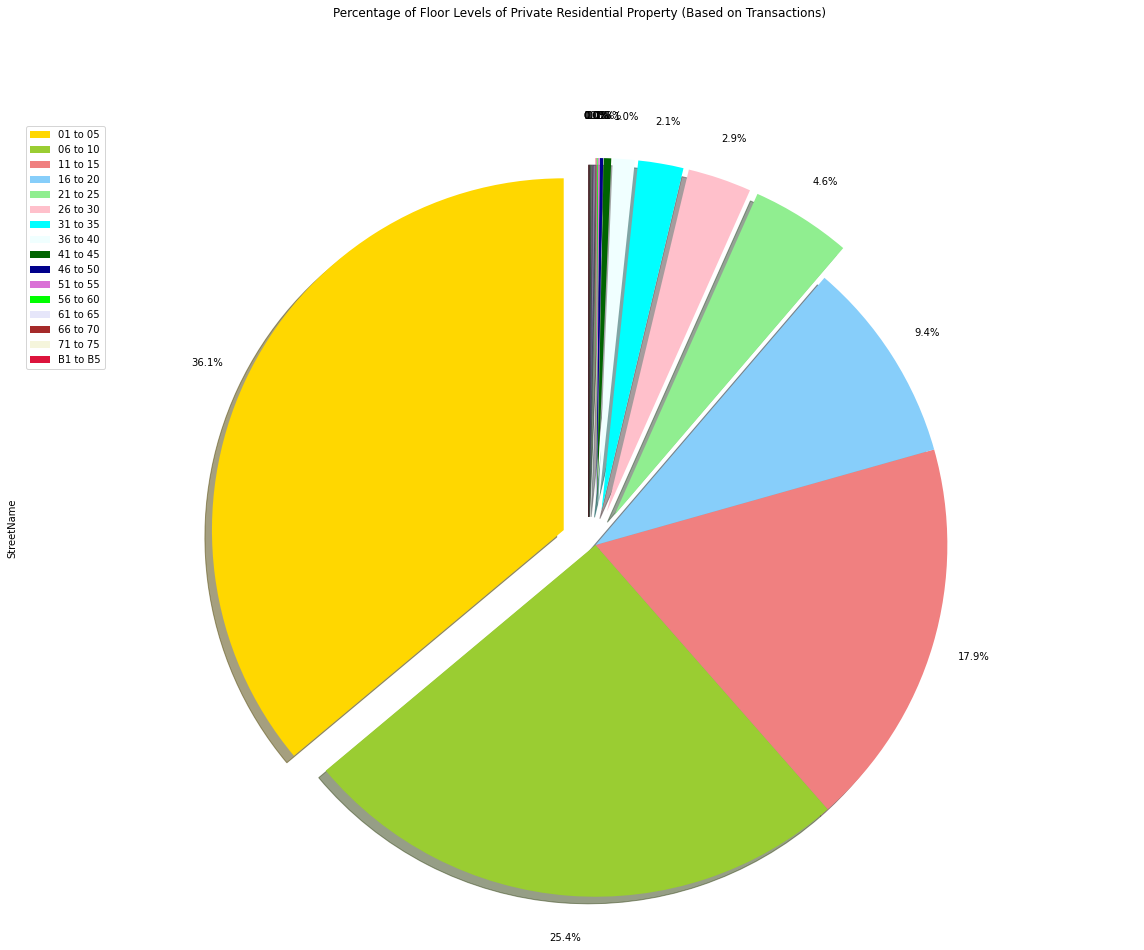

In [18]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'aqua', 'azure', 'darkgreen', 'darkblue', 'orchid', 'lime', 'lavender', 'brown', 'beige', 'crimson']
explode_list = [0.1, 0, 0, 0, 0.1, 0.1 ,0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] # ratio for each continent with which to offset each wedge.

floorcount['StreetName'].plot(kind='pie',
                            figsize=(20, 15),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Percentage of Floor Levels of Private Residential Property (Based on Transactions)', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=floorcount.index, loc='upper left') 

plt.show()

In [19]:

pd.set_option('display.float_format', '{:.2f}'.format)
groupfloor = outerdata[['FloorLevel', 'Price']]

groupfloor = groupfloor.groupby(['FloorLevel'],as_index=False).mean()
groupfloor



,FloorLevel,Price
0,-,2365626.75
1,01 to 05,1444281.50
2,06 to 10,1436439.12
3,11 to 15,1482009.38
4,16 to 20,1751855.25
5,21 to 25,1991567.88
6,26 to 30,2142651.75
7,31 to 35,2171716.75
8,36 to 40,1956205.38
9,41 to 45,2521178.00


TypeError: can't multiply sequence by non-int of type 'float'

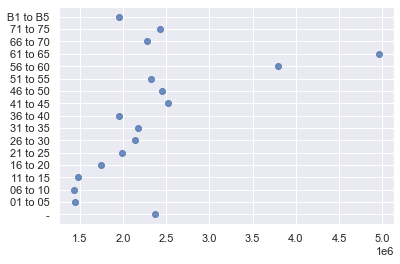

In [20]:


# drop rows: df[~df.C.str.contains("XYZ")]


sns.set(style="darkgrid")
sns.regplot(x="Price", y = "FloorLevel", data=groupfloor)

plt.ylim(0,)

In [113]:
outerdata.groupby('Tenure').count()

grouptenure = outerdata[['Tenure', 'Price']]

grouptenure = grouptenure.groupby(['Tenure'],as_index=False).mean()
grouptenure=grouptenure[~grouptenure['Tenure'].isin(['Freehold'])]
#freehold = grouptenure[grouptenure['Tenure'].str.contains("Freehold")]
#freehold


#grouptenure[['leaseperiod']] = grouptenure.Tenure.str.split(" ",expand= True,)

tenurenew = grouptenure['Tenure'].str.extract('([^a-zA-Z]+)([a-zA-Z]+)', expand=True) #to extract the numbers from alphabets
tenurenew.columns = ['numberyears', 'text']


tenuredata = pd.concat([tenurenew, grouptenure], axis=1).reindex(tenurenew.index)
tenuremean = tenuredata.groupby(['numberyears'], as_index=False).mean()
#tenuremean = mapdata.drop([mapdata.index[709]])
tenuremean.replace(' ', np.nan, inplace = True)
tenuremean.dropna(inplace=True)

#tenuremean["numberyears"]= pd.to_numeric(tenuremean["numberyears"], downcast="float")
tenuremean['numberyears'].astype(object)
tenuremean = tenuremean.sort_values(by=['numberyears'], ascending=True)
#tenuremean = tenuremean.set_index(tenuremean['numberyears'])
tenuremean = tenuremean.append(freehold.iloc[0])

tenuremean['Tenure'].fillna(tenuremean['numberyears'])
tenuremean['numberyears'] = tenuremean['Tenure'].fillna('') + tenuremean['numberyears'].fillna('')
tenuremean.drop('Tenure', axis=1, inplace=True)
tenuremean

,numberyears,Price
1,100,1477587.88
2,101,951154.88
3,102,1272761.62
4,103,1572680.00
5,104,1427744.75
6,110,1693064.62
7,60,534005.06
8,85,940714.31
9,89,1343333.38
10,929,2042475.88


/Users/joshualeow/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:226: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
/Users/joshualeow/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/style.py:27: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


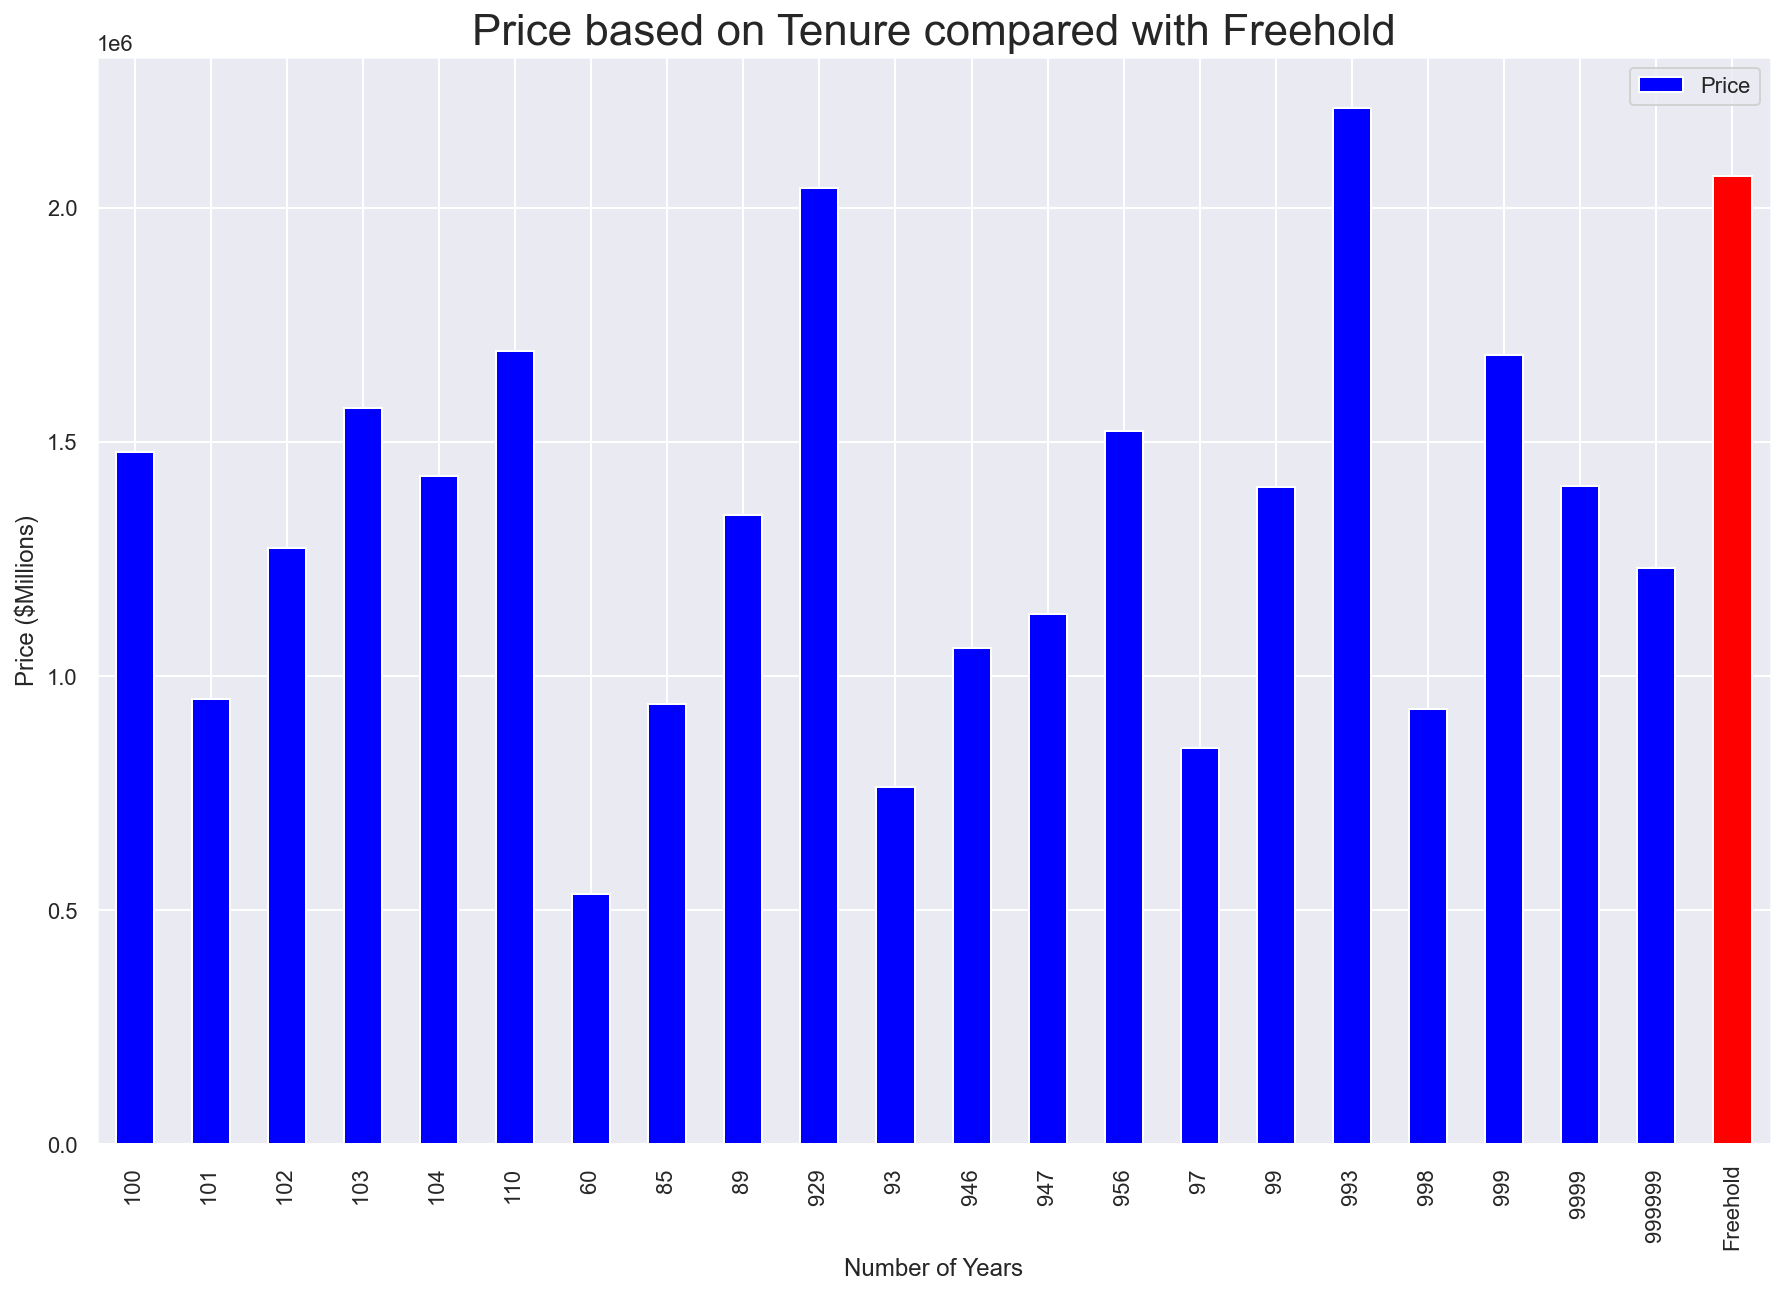

In [114]:
color = 22*['blue']
color[-1] = 'red'
tbar = tenuremean.plot(x='numberyears', y = 'Price', label='Price', colormap = 'Paired', kind='bar', color=color
)



%config InlineBackend.figure_format = 'retina'
plt.title("Price based on Tenure compared with Freehold", size=22)
tbar.set_xlabel("Number of Years")
tbar.set_ylabel('Price ($Millions)')
plt.rcParams["figure.figsize"] = [15,10]


ValueError: x and y must have same first dimension, but have shapes (4,) and (22,)

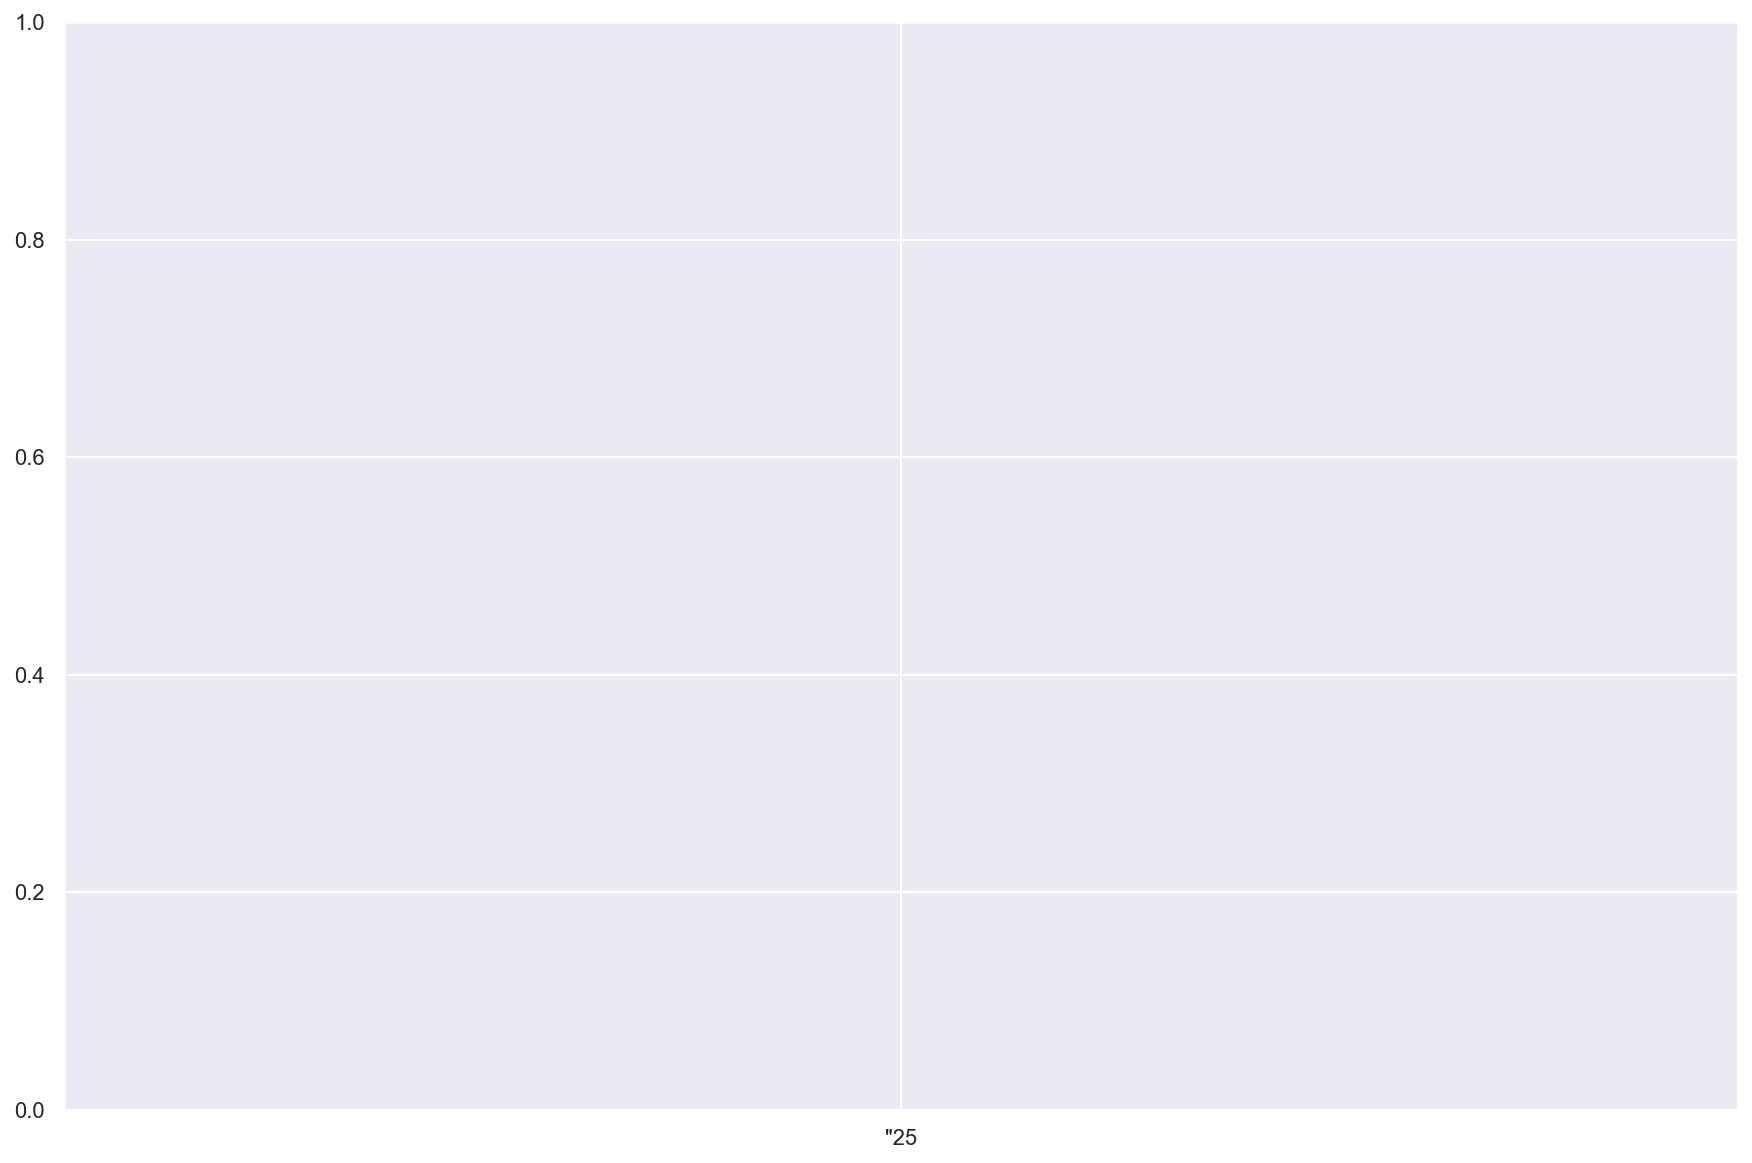

In [ ]:
address = 'Singapore, Singapore'

geolocator = Nominatim(user_agent="sg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

In [ ]:
map_singapore = folium.Map(location=[latitude, longitude], zoom_start=11)


for latitude, longitude, StreetName, Price in zip(mapdata['latitude'], mapdata['longitude'], mapdata['StreetName'], mapdata['Price']):
    label = '{}, {}'.format(Price, StreetName)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)  
    
map_singapore

<h3>Notice that the private apartments/condominiums are largely located in the southern part of Singapore.</h3>

In [ ]:
CLIENT_ID = 'K4YZ0DCCW2EWL5RQQTVEP0FU4C43H3JOWDIYETH2XDMSN45C' 
CLIENT_SECRET = 'Y14VBD21PTLCX1OIIEO3EBMTNPH3ATIIZFT3BQCGKUAS5LH3' 
VERSION = '20180605' 
LIMIT = 100 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [ ]:
outerdata.loc[0, 'StreetName']

In [ ]:
street_latitude = outerdata.loc[0, 'latitude'] # street latitude value
street_longitude = outerdata.loc[0, 'longitude'] # street longitude value

street_name = outerdata.loc[0, 'StreetName'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(street_name, 
                                                               street_latitude, 
                                                               street_longitude))

In [ ]:
LIMIT = 100
radius = 500


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    street_latitude, 
    street_longitude, 
    radius, 
    LIMIT)
url 

In [ ]:
results = requests.get(url).json()
results

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Street', 
                  'Street Latitude', 
                  'Street Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

nearby_venues

In [ ]:
singapore_venues = getNearbyVenues(names=mapdata['StreetName'],
                                   latitudes=mapdata['latitude'],
                                   longitudes=mapdata['longitude']
                                  )

In [ ]:

singapore_venues.head
singapore_venues = singapore_venues.str.replace('B', 'Bishopsgate')

In [ ]:
venuesper = singapore_venues.groupby('Street').count()

print('There are {} uniques categories.'.format(len(singapore_venues['Venue Category'].unique())))
venuesper

In [ ]:
# one hot encoding
singapore_onehot = pd.get_dummies(singapore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
singapore_onehot['Street'] = singapore_venues['Street'] 

# move neighborhood column to the first column
fixed_columns = [singapore_onehot.columns[-1]] + list(singapore_onehot.columns[:-1])
singapore_onehot = singapore_onehot[fixed_columns]

singapore_onehot.shape

singapore_grouped = singapore_onehot.groupby('Street').mean().reset_index()
singapore_grouped.shape

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Street']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
street_venues_sorted = pd.DataFrame(columns=columns)
street_venues_sorted['Street'] = singapore_grouped['Street']

for ind in np.arange(singapore_grouped.shape[0]):
    street_venues_sorted.iloc[ind, 1:] = return_most_common_venues(singapore_grouped.iloc[ind, :], num_top_venues)

street_venues_sorted.head(10)

In [ ]:
# set number of clusters
kclusters = 5

singapore_grouped_clustering = singapore_grouped.drop('Street', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(singapore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
r = requests.get(url)
soup = BeautifulSoup(r.content, "html.parser")
table=soup.find_all('table')

table


table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df